In [492]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

In [493]:
df = pd.read_csv('/content/energydata.csv', index_col='Date', parse_dates=True)

In [494]:
df.head()

,Energy Consumption
Date,
2020-01-01,305.311409
2020-01-02,299.374329
2020-01-03,307.646359
2020-01-04,316.811967
2020-01-05,299.651923


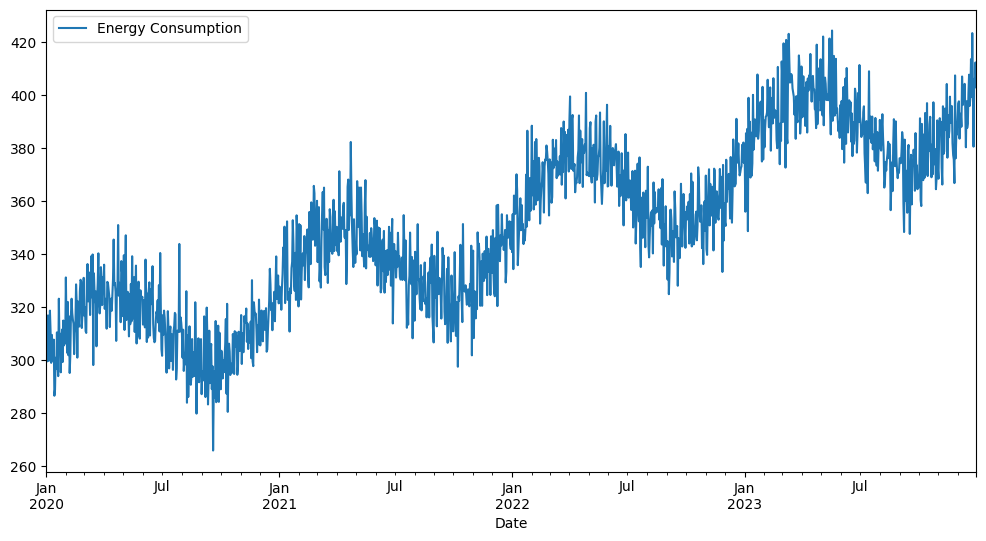

In [495]:
df.plot(figsize=(12, 6))
plt.show()

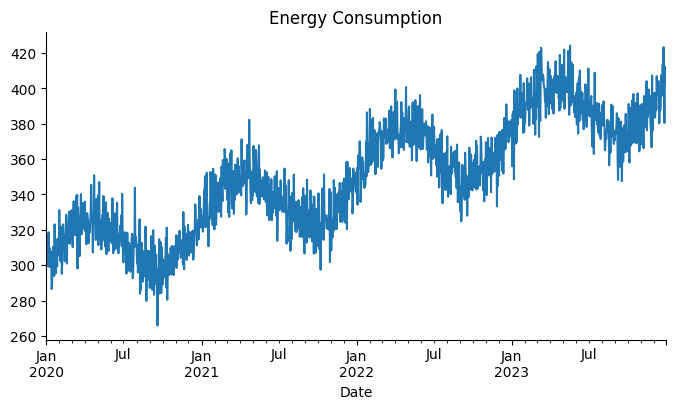

In [496]:
from matplotlib import pyplot as plt
df['Energy Consumption'].plot(kind='line', figsize=(8, 4), title='Energy Consumption')
plt.gca().spines[['top', 'right']].set_visible(False)

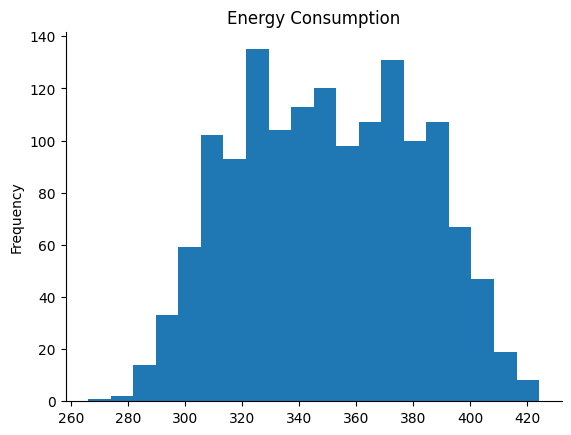

In [497]:
# Energy Consumption
from matplotlib import pyplot as plt
df['Energy Consumption'].plot(kind='hist', bins=20, title='Energy Consumption')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [498]:
from statsmodels.tsa.seasonal import seasonal_decompose

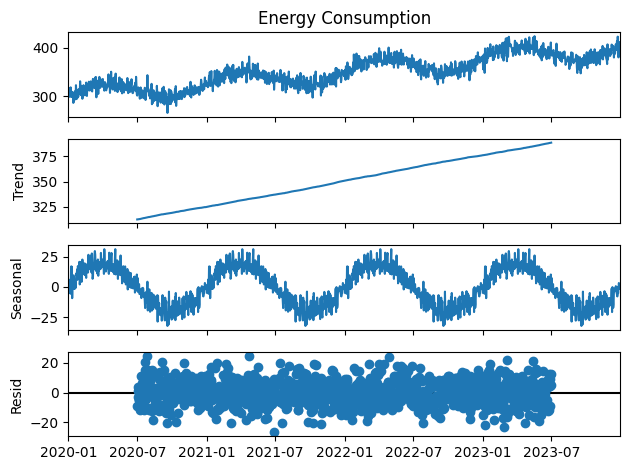

In [499]:
result = seasonal_decompose(df['Energy Consumption'], model='additive', period=365)
fig = result.plot()
plt.show()

In [500]:
df.describe()


,Energy Consumption
count,1460.000000
mean,350.451726
std,31.566215
min,265.886301
25%,324.913290
50%,349.962555
75%,375.550666
max,424.172656


In [501]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
df_scaled.head()

,Energy Consumption
Date,
2020-01-01,0.249075
2020-01-02,0.211566
2020-01-03,0.263826
2020-01-04,0.321731
2020-01-05,0.213320


In [502]:
# print how many years in the dataset
print('Number of years in the dataset:', len(df.index.year.unique()))

Number of years in the dataset: 4


In [503]:
# split data into testing and training, 3 years to train, 1 year to test
train_size = len(df) - 364
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]
train_data = train_data[['Energy Consumption']]

# display tail of train_data and head of test_data
print('Train data tail:\n', train_data.tail())
print('Test data head:\n', test_data.head())

Train data tail:
             Energy Consumption
Date                          
2022-12-27            0.676891
2022-12-28            0.727816
2022-12-29            0.687735
2022-12-30            0.733346
2022-12-31            0.684569
Test data head:
             Energy Consumption
Date                          
2023-01-01            0.697244
2023-01-02            0.568644
2023-01-03            0.755380
2023-01-04            0.721984
2023-01-05            0.765746


In [504]:
def detect_and_replace_outliers(df, column='Energy Consumption', window=14, threshold=0.8):
    """
    Detect and replace outliers using seasonal patterns

    Parameters:
    df: DataFrame with datetime index
    column: column name to check for outliers
    window: rolling window size for seasonal pattern
    threshold: IQR threshold for outlier detection
    """
    df_processed = df.copy()
    df_processed['outlier'] = False

    # Create a rolling median for comparison
    df_processed['rolling_median'] = df_processed[column].rolling(
        window=window, center=True, min_periods=1
    ).median()

    # Create rolling IQR bounds
    rolling_Q1 = df_processed[column].rolling(window=window, center=True, min_periods=1).quantile(0.25)
    rolling_Q3 = df_processed[column].rolling(window=window, center=True, min_periods=1).quantile(0.75)
    rolling_IQR = rolling_Q3 - rolling_Q1

    lower_bound = rolling_Q1 - threshold * rolling_IQR
    upper_bound = rolling_Q3 + threshold * rolling_IQR

    # Identify outliers
    outliers_mask = (df_processed[column] < lower_bound) | (df_processed[column] > upper_bound)
    df_processed.loc[outliers_mask, 'outlier'] = True

    # Store original values before replacement
    original_values = df_processed.loc[outliers_mask, column].copy()

    # Replace outliers with interpolated values
    for idx in df_processed[outliers_mask].index:
        # Get the season-specific window
        season_start = idx - pd.Timedelta(days=window//2)
        season_end = idx + pd.Timedelta(days=window//2)

        # Get non-outlier values in the seasonal window
        seasonal_values = df_processed[
            (df_processed.index >= season_start) &
            (df_processed.index <= season_end) &
            (~df_processed['outlier'])
        ][column]

        if len(seasonal_values) > 0:
            # Replace with median of seasonal non-outlier values
            df_processed.loc[idx, column] = seasonal_values.median()
        else:
            # If no good seasonal values, use rolling median
            df_processed.loc[idx, column] = df_processed.loc[idx, 'rolling_median']

    # Plotting
    plt.figure(figsize=(15, 10))

    # Plot original data
    plt.subplot(2, 1, 1)
    plt.plot(df_processed.index, df_processed[column], label='Data with Outliers', alpha=0.7)
    plt.scatter(original_values.index, original_values,
               color='red', label='Detected Outliers', alpha=0.5)
    plt.title('Original Data with Detected Outliers')
    plt.legend()
    plt.grid(True)

    # Plot processed data
    plt.subplot(2, 1, 2)
    plt.plot(df_processed.index, df_processed[column],
             label='Data with Replaced Outliers', color='green')
    plt.title('Data with Replaced Outliers')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print statistics
    num_outliers = outliers_mask.sum()
    print(f"\nOutlier Statistics:")
    print(f"Total data points: {len(df)}")
    print(f"Outliers detected and replaced: {num_outliers} ({num_outliers/len(df)*100:.2f}%)")

    # Drop the helper columns
    df_processed.drop(['rolling_median', 'outlier'], axis=1, inplace=True)

    return df_processed

In [505]:
# Create weekly plots with outliers highlighted
def plot_weekly_outliers(df, df_with_outliers, bounds_dict, week_length=7):
    num_chunks = len(df) // week_length + (1 if len(df) % week_length != 0 else 0)
    num_cols = 2
    num_rows = (num_chunks + 1) // 2

    plt.figure(figsize=(15, 5 * num_rows))

    for i in range(num_chunks):
        plt.subplot(num_rows, num_cols, i + 1)

        start_idx = i * week_length
        end_idx = min((i + 1) * week_length, len(df))

        chunk = df.iloc[start_idx:end_idx]
        chunk_outliers = df_with_outliers[
            (df_with_outliers.index >= chunk.index[0]) &
            (df_with_outliers.index <= chunk.index[-1]) &
            df_with_outliers['outlier']
        ]

        # Plot regular data points
        plt.plot(chunk.index, chunk['Energy Consumption'],
                label='Regular Data', color='blue')

        # Plot outliers
        if not chunk_outliers.empty:
            plt.scatter(chunk_outliers.index,
                       chunk_outliers['Energy Consumption'],
                       color='red', label='Outliers')

        # Plot bounds
        lower_bound, upper_bound = bounds_dict[i]
        plt.axhline(y=lower_bound, color='g', linestyle='--',
                   label='Lower Bound')
        plt.axhline(y=upper_bound, color='g', linestyle='--',
                   label='Upper Bound')

        plt.title(f'week {i+1}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [506]:
# Apply the weekly outlier detection
# First ensure the index is datetime
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

# Detect outliers with different season lengths and thresholds
week_length = 7
threshold = 1

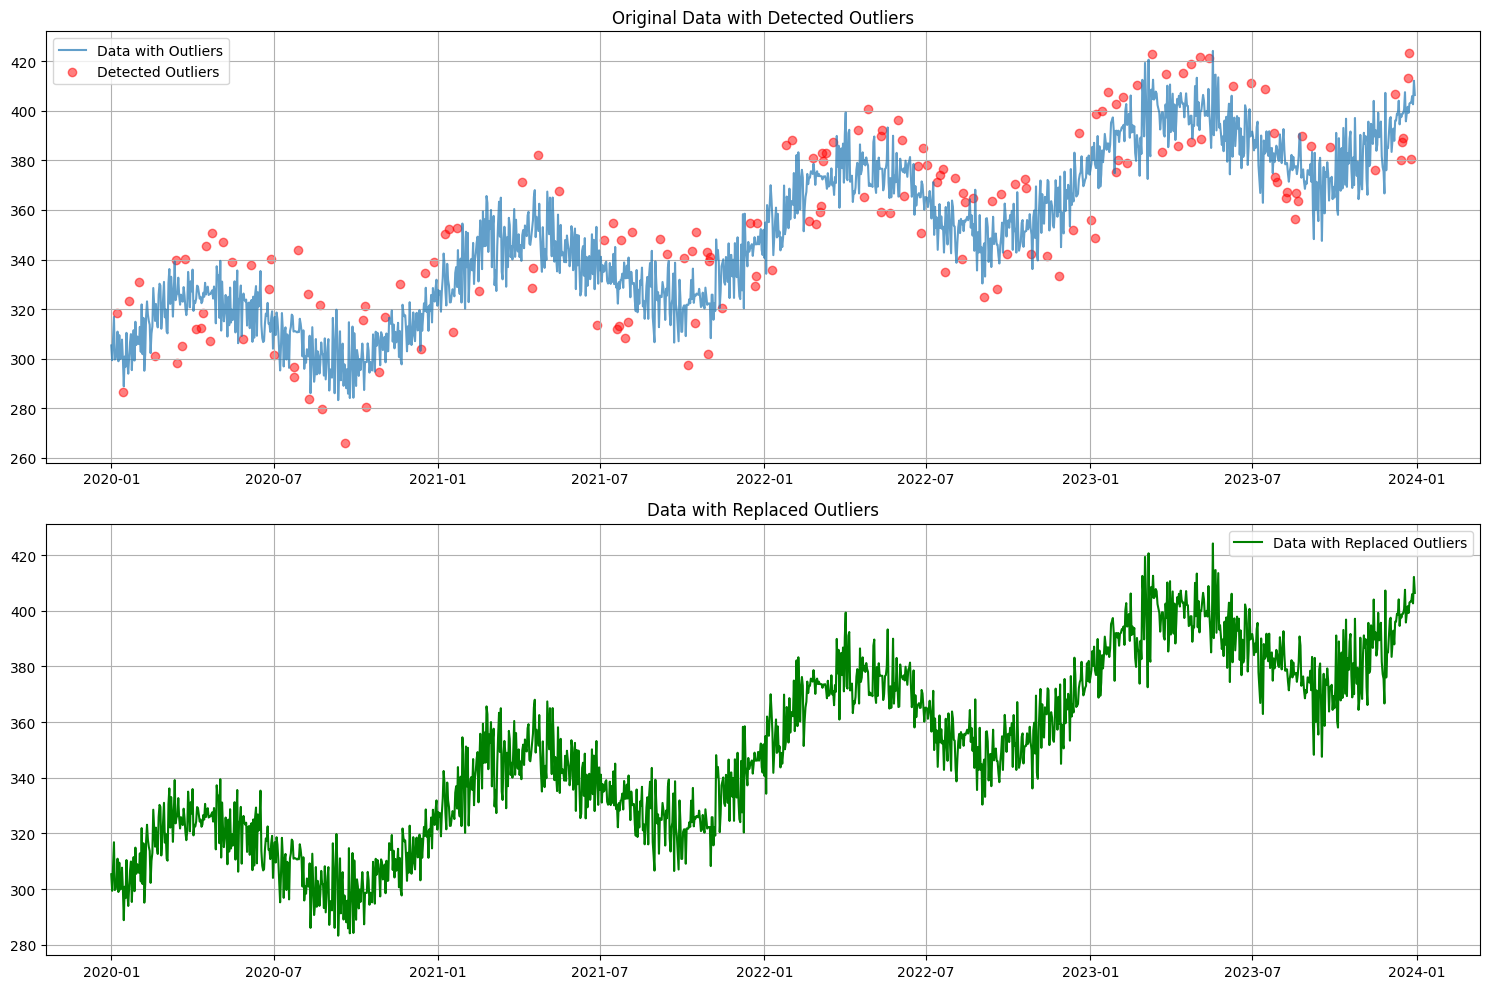


Outlier Statistics:
Total data points: 1460
Outliers detected and replaced: 165 (11.30%)


In [507]:
results = {}
processed_df = detect_and_replace_outliers(
            df, window=14, threshold=0.8
        )
results[(14, 0.8)] = processed_df



In [508]:
final_processed_df = results[(14, 0.8)]

In [509]:
# Prepare the processed data for modeling
def prepare_processed_data(processed_data):
    """
    Prepare the processed data for modeling
    """
    # Scale the data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(
        scaler.fit_transform(processed_data[['Energy Consumption']]),
        columns=['Energy Consumption'],
        index=processed_data.index
    )

    # Split into train and test
    train_size = len(scaled_data) - 364
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    return train_data, test_data, scaler

# Prepare the data
train_data, test_data, scaler = prepare_processed_data(final_processed_df)

print("\nFinal Dataset Shapes:")
print(f"Training data: {train_data.shape}")
print(f"Test data: {test_data.shape}")


Final Dataset Shapes:
Training data: (1096, 1)
Test data: (364, 1)


In [510]:
# Convert train_data to a NumPy array
train_data_np = train_data.values
test_data_np = test_data.values


In [511]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [512]:
# Define the generator for one-step prediction
n_steps=30
one_step_generator = TimeseriesGenerator(train_data_np, train_data_np, length= n_steps, batch_size=3)

In [513]:
# Define the number of steps to predict
# n_steps = 7

# # Adjust the multi-step targets to match the length of train_data
# multi_step_targets = np.array([train_data_np[i:i+n_steps] for i in range(len(train_data_np) - n_steps)])
# multi_step_data = train_data_np[:len(multi_step_targets)]

# # create the generator with the adjusted data and targets
# multi_step_generator = TimeseriesGenerator(multi_step_data, multi_step_targets, length=30, batch_size=3)

In [514]:
one_time_X, one_time_y = one_step_generator[0]
# print length of X and Y
print(f'Length of X: {len(one_time_X)}')
print(f'Length of y: {len(one_time_y)}')

Length of X: 3
Length of y: 3


In [515]:
# Access the first sample within the batch
single_X, single_y = one_time_X[0], one_time_y[0]
print(f'Single X:\n {single_X.flatten()}')
print(f'Single y:\n {single_y}')

Single X:
 [0.15656022 0.11443069 0.17312903 0.23816822 0.11640049 0.11932008
 0.13842044 0.19621478 0.11134693 0.18605771 0.11756307 0.12028066
 0.17337154 0.11892186 0.03951903 0.12486224 0.09572314 0.19271202
 0.10878613 0.07579546 0.12486224 0.16553426 0.18909556 0.08593577
 0.15112183 0.20032008 0.11345402 0.22444881 0.15780914 0.18235297]
Single y:
 [0.16295476]


In [516]:
# multi_time_X, multi_time_y = multi_step_generator[0]
# # print length of X and Y
# print(f'Length of X: {len(multi_time_X)} , X shape {multi_time_X.shape}')
# print(f'Length of y: {len(multi_time_y)}')

In [517]:
# # Access the first sample within the batch
# multi_single_X, multi_single_y = multi_time_X[0], multi_time_y[0]
# print(f'we give this Single X:\n {multi_single_X.flatten()}')
# print(f'we predict this Single y:\n {multi_single_y}')

In [518]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [519]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(30, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [520]:
# model2 = Sequential()
# model2.add(LSTM(100, activation='relu', input_shape=(30, 1)))
# model2.add(Dense(7))
# model2.compile(optimizer='adam', loss='mse')

In [521]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [522]:
#fit model
model.fit(one_step_generator, epochs=50)

Epoch 1/50
 15/356 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0830

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



356/356 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0176
Epoch 2/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0036
Epoch 3/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0038
Epoch 4/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0036
Epoch 5/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0036
Epoch 6/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0038
Epoch 7/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0036
Epoch 8/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0035
Epoch 9/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0036
Epoch 10/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0037
Epoch 11/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0037
Epoch 12/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0035
Epoch 13/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0037
Epoch 14/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0037
Epoch 15/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step

In [523]:
# model2.fit(multi_step_generator, epochs=50)

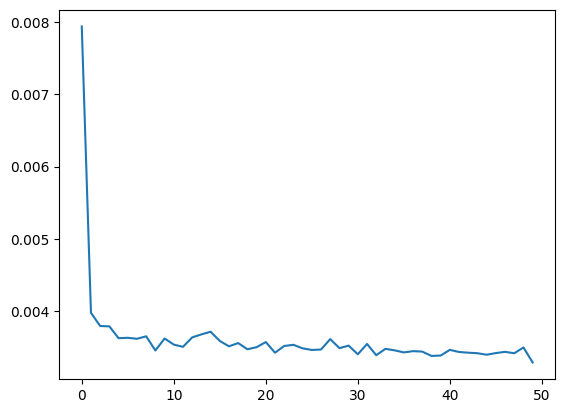

In [524]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [525]:
 # Get the last 30 days from training data
last_sequence = train_data_np[-n_steps:]

# Reshape the data for LSTM [samples, time steps, features]
X_pred = last_sequence.reshape((1, n_steps, 1))

# Make prediction
prediction = model.predict(X_pred, verbose=0)
print( prediction[0])

[0.6607735]


In [526]:
# Get the actual first day from test data for comparison
actual_first_day = test_data_np[0]
print(actual_first_day)

[0.65994469]


In [527]:
print(f'Predicted value: {prediction[0]}')
print(f'Actual value: {actual_first_day[0]}')
print(f'Difference: {abs(prediction[0] - actual_first_day[0])}')

Predicted value: [0.6607735]
Actual value: 0.659944686834347
Difference: [0.0008288]


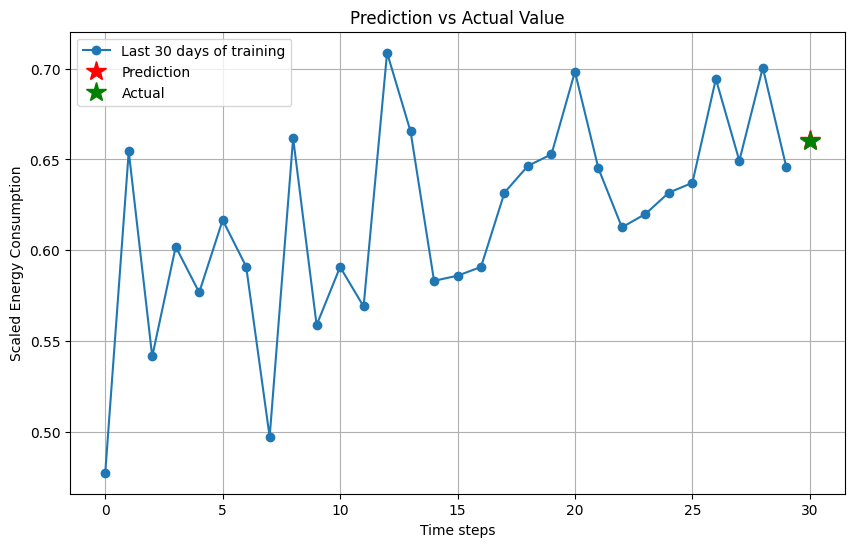

In [528]:
# lets Visualize the prediction
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_data_np[-n_steps:].flatten())), train_data_np[-n_steps:].flatten(),
         label='Last 30 days of training', marker='o')
plt.plot(n_steps, prediction[0], 'r*', markersize=15, label='Prediction')
plt.plot(n_steps, actual_first_day[0], 'g*', markersize=15, label='Actual')
plt.xlabel('Time steps')
plt.ylabel('Scaled Energy Consumption')
plt.title('Prediction vs Actual Value')
plt.legend()
plt.grid(True)
plt.show()

In [529]:
predictions = []
current_sequence = train_data_np[-n_steps:].copy()

# Predict each day in the test period
for i in range(len(test_data_np)):
    # Reshape current sequence for prediction
    X = current_sequence.reshape((1, n_steps, 1))

    # Predict next value
    next_pred = model.predict(X, verbose=0)[0][0]
    predictions.append(next_pred)

    # Update sequence by removing first element and adding the actual test value
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[-1] = test_data_np[i]

In [530]:
test_dates = test_data.index if hasattr(test_data, 'index') else np.arange(len(test_data_np))

In [531]:
# Calculate error metrics
mse = mean_squared_error(test_data_np, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_np, predictions)
r2 = r2_score(test_data_np, predictions)

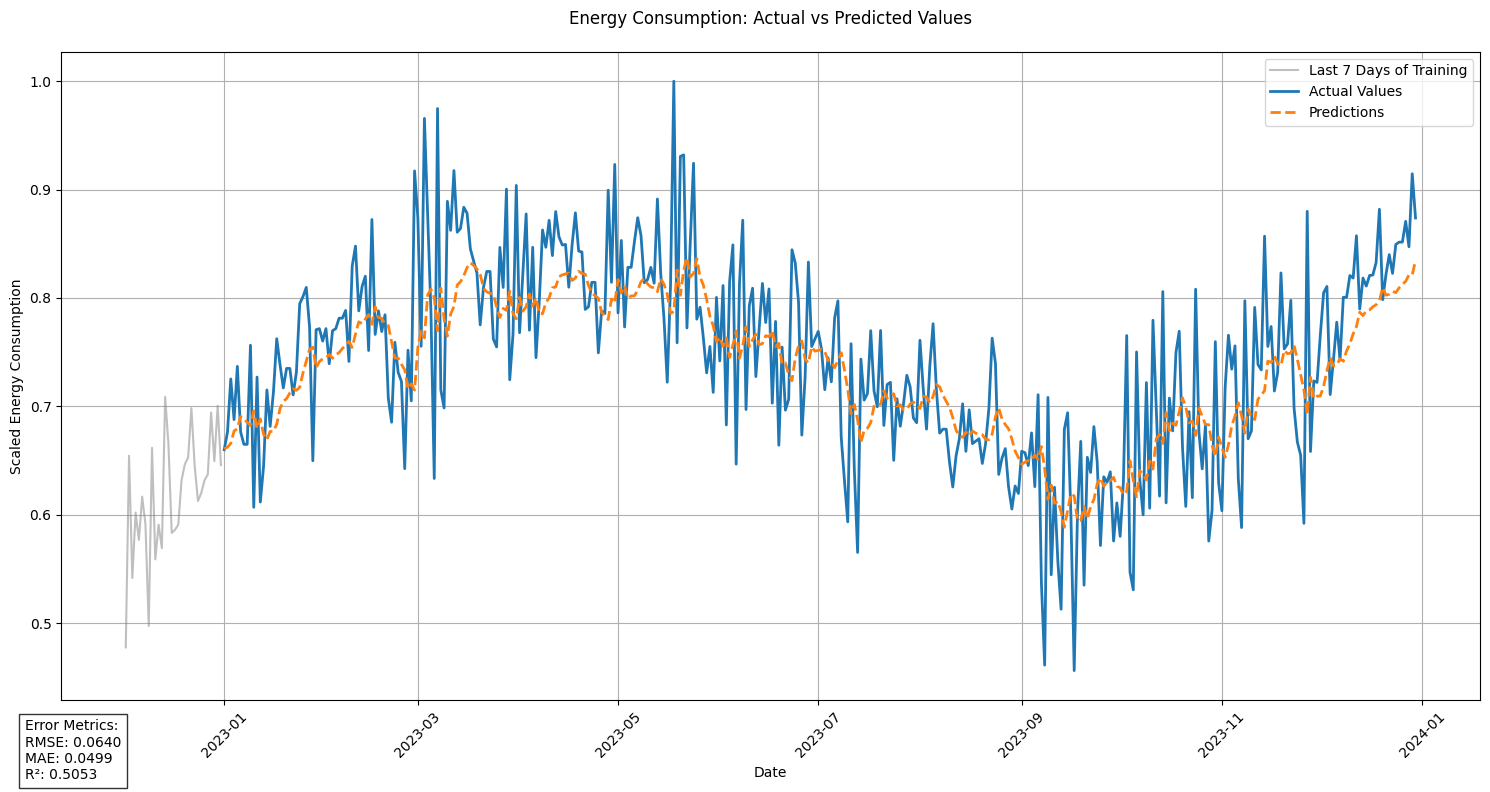

In [532]:
# Plotting
plt.figure(figsize=(15, 8))

# Plot the last 30 days of training data
train_dates = train_data.index[-n_steps:] if hasattr(train_data, 'index') else np.arange(-n_steps, 0)
plt.plot(train_dates, train_data_np[-n_steps:],
         label='Last 7 Days of Training',
         color='gray',
         alpha=0.5)

# Plot test data and predictions
plt.plot(test_dates, test_data_np,
         label='Actual Values',
         linewidth=2)
plt.plot(test_dates, predictions,
         label='Predictions',
         linewidth=2,
         linestyle='--')

plt.title('Energy Consumption: Actual vs Predicted Values', pad=20)
plt.xlabel('Date')
plt.ylabel('Scaled Energy Consumption')
plt.legend()
plt.grid(True)

# Add error metrics as text box
metrics_text = f'Error Metrics:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}'
plt.figtext(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Rotate x-axis labels if using dates
if hasattr(test_data, 'index'):
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [533]:
# Print detailed metrics
print("\nDetailed Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Calculate and display some additional analysis
print("\nPrediction Analysis:")
print(f"Mean Actual Value: {np.mean(test_data_np):.4f}")
print(f"Mean Predicted Value: {np.mean(predictions):.4f}")
print(f"Std Actual Value: {np.std(test_data_np):.4f}")
print(f"Std Predicted Value: {np.std(predictions):.4f}")


Detailed Performance Metrics:
Root Mean Squared Error (RMSE): 0.0640
Mean Absolute Error (MAE): 0.0499
R-squared (R²): 0.5053

Prediction Analysis:
Mean Actual Value: 0.7451
Mean Predicted Value: 0.7330
Std Actual Value: 0.0910
Std Predicted Value: 0.0612


In [534]:
# Create a dataframe with the results
results_df = pd.DataFrame({
    'Actual': test_data_np.flatten(),
    'Predicted': predictions,
    'Absolute_Error': np.abs(test_data_np.flatten() - predictions)
})

print("\nWorst 5 Predictions (highest absolute error):")
print(results_df.nlargest(5, 'Absolute_Error'))


Worst 5 Predictions (highest absolute error):
       Actual  Predicted  Absolute_Error
137  1.000000   0.787459        0.212541
65   0.974824   0.769684        0.205140
61   0.965729   0.763169        0.202560
58   0.917254   0.714936        0.202319
330  0.879928   0.692406        0.187522
